In [1]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.FileFormat import *
from WPI_SCA_LIBRARY.DPA import *
from WPI_SCA_LIBRARY.LeakageModels import *
from WPI_SCA_LIBRARY.Metrics import *
from WPI_SCA_LIBRARY.PicoScope import *
from ipywidgets import interact

In [2]:
fp = FileParent("Demo_file", ".", False)
target = CWScope("../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-CWLITEARM.hex", target_type=cw.targets.SimpleSerial2)
#known key: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c

(ChipWhisperer Other ERROR|File util.py:362) Setting unknown attribute offset in <class 'chipwhisperer.capture.scopes.OpenADC.OpenADC'>


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6163 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6163 bytes


In [3]:
scope = PicoScope()

In [4]:
scope.ch_setup()

Channel A configured: AC, 50 mV range.
Channel B configured: DC, 2000 mV range.


In [5]:
scope.set_trigger_simple()

Trigger configured on Channel B (threshold 1800 mV, rising edge).


In [6]:
scope.cw_pico_capture(target, fp, samples_per_run = 50000, num_traces = 2500, experiment_name = "Exp1")

Data buffer allocated (50000 samples per capture).
Beginning capture loop (2500 acquisitions)...


100%|██████████| 2500/2500 [03:15<00:00, 12.78it/s]


Capture complete. Data shape:  (2500, 50000)


In [7]:
my_plaintext = fp.get_experiment("Exp1").get_dataset("Pico_Capture_Plaintexts").read_all()
my_traces = fp.get_experiment("Exp1").get_dataset("Pico_Capture_Traces").read_all()

In [12]:
key_ranks = np.empty(256, dtype=object)
key_scores = np.empty(256, dtype=object)
key_candidates = range(256)
for i in range(16):
    ranks_scores = score_and_rank(key_candidates, i, my_traces, score_with_correlation, my_plaintext, leakage_model_hamming_weight)
    print("Highest Ranked Key Guess: {} with score {}".format(hex(ranks_scores[0][0]), ranks_scores[0][1]))

Highest Ranked Key Guess: 0x2b with score 0.2764460566461418
Highest Ranked Key Guess: 0x7e with score 0.20073532514797682
Highest Ranked Key Guess: 0x15 with score 0.2428747250149427
Highest Ranked Key Guess: 0x16 with score 0.2553911194634048
Highest Ranked Key Guess: 0x28 with score 0.24328508571191065
Highest Ranked Key Guess: 0xae with score 0.2336578886179156
Highest Ranked Key Guess: 0xd2 with score 0.2421146339086281
Highest Ranked Key Guess: 0xa6 with score 0.24297078651519372
Highest Ranked Key Guess: 0xab with score 0.23043332408498374
Highest Ranked Key Guess: 0xf7 with score 0.23615689534059967
Highest Ranked Key Guess: 0x15 with score 0.24131322933585742
Highest Ranked Key Guess: 0x88 with score 0.2503393783705354
Highest Ranked Key Guess: 0x9 with score 0.22478780368874274
Highest Ranked Key Guess: 0xcf with score 0.284287792214503
Highest Ranked Key Guess: 0x4f with score 0.2609107594574608
Highest Ranked Key Guess: 0x3c with score 0.21609513553921042


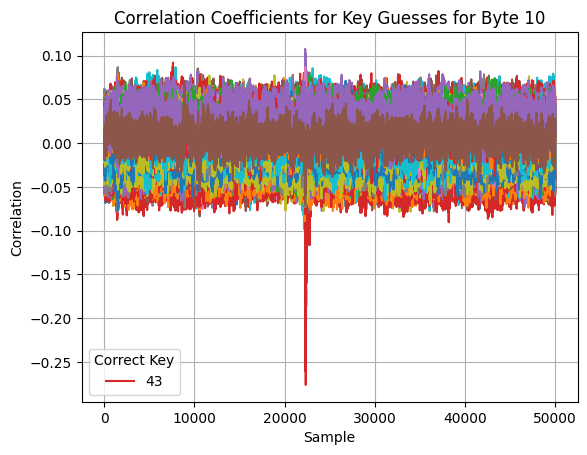

In [13]:
for k in range(0, 256):        
    leakage = leakage_model_hamming_weight(num_traces=2500, plaintexts=my_plaintext, subkey_guess=k, target_byte=0)
    correlation = pearson_correlation(leakage, my_traces)
    if k == 43:
        plt.plot(correlation, label=k)
    else:
        plt.plot(correlation)
plt.legend(title="Correct Key")
plt.title("Correlation Coefficients for Key Guesses for Byte 0")
plt.xlabel("Sample")
plt.ylabel("Correlation")
plt.grid()
plt.show()